In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from pathlib import Path
import os
from tqdm import tqdm
import sklearn.metrics
#import sklearn.preprocessing.OneHotE

In [3]:
#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

In [4]:
tf.__version__

'2.1.0'

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AvgPool2D

In [17]:
train_df = pd.read_csv('../data/train.csv')
strs = train_df['image_id'].values
strs = [string+'_f.png' for string in strs]
train_df.drop(['image_id'],axis=1,inplace=True)
train_df['image_id'] = strs

In [18]:
#train_df = train_df.astype(str)
train_df.dtypes

grapheme_root           int64
vowel_diacritic         int64
consonant_diacritic     int64
grapheme               object
image_id               object
dtype: object

In [19]:
def apply_augmentation(image):
    augmentation_pipeline = A.Compose(
        [
            A.OneOf(
                [
                    # apply one of transforms to 50% of images
                    A.RandomContrast(), # apply random contrast
                    A.RandomGamma(), # apply random gamma
                    A.RandomBrightness(), # apply random brightness
                ],
                p = 0.5
            ),
            A.OneOf(
                [
                    # apply one of transforms to 50% images
                    A.ElasticTransform(alpha = 120,sigma = 120 * 0.05,alpha_affine = 120 * 0.03),
                    A.GridDistortion(),
                    A.OpticalDistortion(distort_limit = 2,shift_limit = 0.5),
                ],
                p = 0.5
            )
        ],
        p = 0.5
    )
    images_aug = augmentation_pipeline(image = image)['image']
    return images_aug

In [20]:
def modified_recall(y_true, y_pred):
    
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    
    final_score = np.average(scores, weights=[2,1,1])

In [21]:
datadir_toy_processed_images = '/home/sayan/Documents/Bengali_Grapheme/images/toy_processed_images'
train_df_sample = pd.DataFrame()
for (directory, _ , image_names) in os.walk(datadir_toy_processed_images):
        train_df_sample = train_df[train_df['image_id'].isin(image_names)]

In [233]:
im_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                               preprocessing_function=apply_augmentation)


gen_image = im_generator.flow_from_dataframe(train_df_sample,
                                             directory='/home/sayan/Documents/Bengali_Grapheme/images/toy_processed_images',
                                             x_col='image_id',
                                             y_col=['grapheme_root','vowel_diacritic','consonant_diacritic'],
                                             target_size = (64,64),
                                             class_mode = 'multi_output',
                                             color_mode = 'grayscale',
                                             shuffle=False, 
                                             batch_size = 32,
                                             seed=42)

Found 20084 validated image filenames.


In [215]:
def oneHotEncode_outputs(gen_image):
    while True:
        output = next(gen_image)
        img = output[0]
        labels = output[1]
        #grapheme_label = np.zeros(168)
        #vowel_label = np.zeros(11)
        #consonant_label = np.zeros(7)
        for i in range(3):
            if i == 0:
                a = labels[i]
                b = np.zeros((a.size, 168))
                b[np.arange(a.size),a] = 1
                labels[i] = b
            elif i == 1:
                a = labels[i]
                b = np.zeros((a.size, 11))
                b[np.arange(a.size),a] = 1
                labels[i] = b
            else:
                a = labels[i]
                b = np.zeros((a.size, 7))
                b[np.arange(a.size),a] = 1
                labels[i] = b
        yield (img, labels)

In [216]:
val = next(gen_image)

In [220]:
val

(array([[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         ...,
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]]], dtype=float32), [array([107]), array([0]), array([3])])

In [218]:
data_gen = oneHotEncode_outputs(gen_image)

In [219]:
next(data_gen)

(array([[[[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.32941177],
          [0.01176471],
          [0.        ]],
 
         [[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [1.        ],
          [0.2509804 ],
          [0.        ]],
 
         [[0.01960784],
          [0.1764706 ],
          [0.        ],
          ...,
          [1.        ],
          [0.7176471 ],
          [0.01960784]],
 
         ...,
 
         [[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],
 
         [[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],
 
         [[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]]]], dtype=float3

---

In [234]:
input_ = Input(shape=(64,64,1))

conv1 = Conv2D(filters=6, kernel_size=(3, 3), activation='relu')(input_)
avgpool1 = AvgPool2D()(conv1)

conv2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(avgpool1)
avgpool2 = AvgPool2D()(conv2)

flat = Flatten()(avgpool2)

dense_root_1 = Dense(2000,activation='relu')(flat)
dense_root_2 = Dense(1500,activation='relu')(dense_root_1)
dense_root_3 = Dense(1000,activation='relu')(dense_root_2)
dense_root_4 = Dense(800,activation='relu')(dense_root_3)
dense_root_5 = Dense(250,activation='relu')(dense_root_4)
output_root = Dense(168,activation='softmax')(dense_root_4)

dense_vowel_1 = Dense(800,activation='relu')(flat)
dense_vowel_2 = Dense(600,activation='relu')(dense_vowel_1)
dense_vowel_3 = Dense(100,activation='relu')(dense_vowel_2)
output_vowel = Dense(11,activation='softmax')(dense_vowel_3)

dense_consonant_1 = Dense(800,activation='relu')(flat)
dense_consonant_2 = Dense(600,activation='relu')(dense_consonant_1)
dense_consonant_3 = Dense(100,activation='relu')(dense_consonant_2)
output_consonant = Dense(7,activation='softmax')(dense_consonant_3)



model = keras.Model(inputs=[input_],outputs=[output_root,output_vowel,output_consonant])
model.compile(loss = keras.losses.sparse_categorical_crossentropy,
              optimizer = 'sgd',
              metrics=['accuracy'])

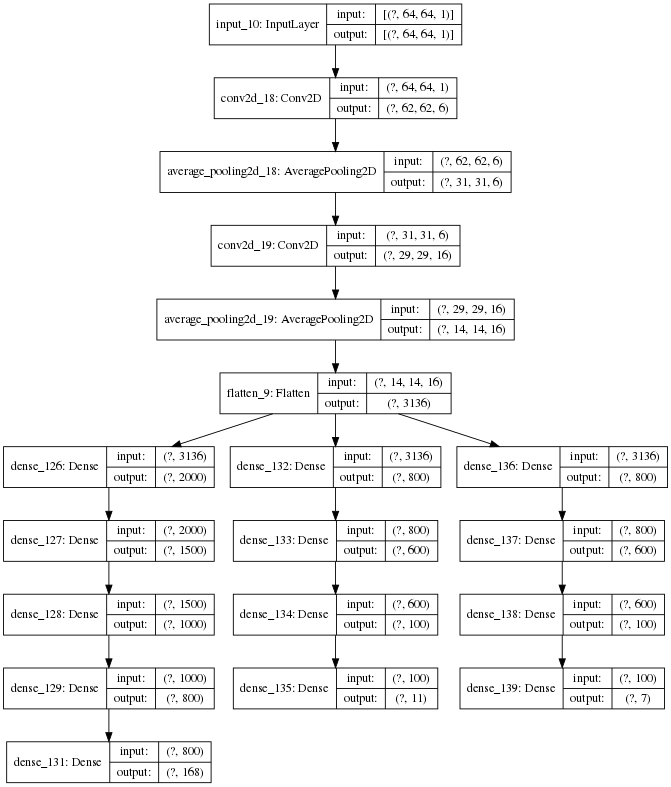

In [235]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
history = model.fit(gen_image,epochs = 10)

Train for 628 steps
Epoch 1/10
628/628 [==============================] - 62s 99ms/step - loss: 7.8956 - dense_131_loss: 4.8024 - dense_135_loss: 1.9470 - dense_139_loss: 1.1462 - dense_131_accuracy: 0.0270 - dense_135_accuracy: 0.2907 - dense_139_accuracy: 0.6309
Epoch 2/10
628/628 [==============================] - 61s 96ms/step - loss: 7.3082 - dense_131_loss: 4.6311 - dense_135_loss: 1.6624 - dense_139_loss: 1.0147 - dense_131_accuracy: 0.0400 - dense_135_accuracy: 0.3957 - dense_139_accuracy: 0.6499
Epoch 3/10
628/628 [==============================] - 62s 100ms/step - loss: 6.9391 - dense_131_loss: 4.4739 - dense_135_loss: 1.5021 - dense_139_loss: 0.9630 - dense_131_accuracy: 0.0574 - dense_135_accuracy: 0.4568 - dense_139_accuracy: 0.6670
Epoch 4/10
628/628 [==============================] - 62s 98ms/step - loss: 6.6540 - dense_131_loss: 4.3313 - dense_135_loss: 1.3936 - dense_139_loss: 0.9291 - dense_131_accuracy: 0.0714 - dense_135_accuracy: 0.4988 - dense_139_accuracy: 0.6771